In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textblob
from textblob import TextBlob
import scispacy
import re
import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
nltk.download('punkt_tab')
nltk.download('stopwords')
import langid


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vanikanoria/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vanikanoria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# %pip install langid
# !python -m spacy download en_core_web_sm
# %pip install textblob
# %pip install scispacy
# %pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
# %pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941173 sha256=21f3a6c9ab38903c89baccc593140c5cbc7ac6da46eb04fc3d840a39a621b0cf
  Stored in directory: /Users/vanikanoria/Library/Caches/pip/wheels/8d/c7/58/c3746410605ae761662cdf9d9463488edab1e2f5ff3e8f9960
Successfully built langid
Note: you may need to restart the kernel to use updated packages.


In [2]:
messages = pd.read_csv('messages.csv')

In [3]:
messages

,thread_id,timestamp,role,content
0,0,2024-06-07 14:47:59,supervisor,"Good morning, Ms. Cooper - when you have a few..."
1,0,2024-06-10 13:18:38,claimant,1. What is your job title/department? Animal C...
2,0,2024-06-10 13:39:40,supervisor,Thank you!!\n\nEmily Martinez\nSupervisor WC T...
3,0,2024-07-01 19:03:40,supervisor,Hi Sarah - According to the documents from you...
4,0,2024-07-02 3:35:15,claimant,I was unable to make it to an appointment on 6...
...,...,...,...,...
3074,946,2022-07-01 13:39:39,claimant,No thanks
3075,947,2022-10-04 13:30:59,claimant,"Sarah, if you recall in the documentation ther..."
3076,948,2024-09-05 13:56:09,claimant,"Hello, Ms.Smith I sent you & sign the paperwor..."
3077,948,2024-09-13 12:32:02,claimant,"Ms. Smith, I went back to work on September 3r..."


In [4]:
messages.loc[1, 'content']

"1. What is your job title/department? Animal Care Specialist at Riverside County Animal Services.\n2. Who is the department supervisor? Robert Brown\n3. Brief description of accident: As I was exiting the dog's kennel he got excited and and started jumping up and biting at me.\n4. Size of the dog and location on body that you were bitten: Large sized dog and under my right upper arm.\n5. Prior injury to the affected body part? No\n6. Any medical conditions that require maintenance medication? No\n7. Have you missed any time from work as a result of this accident? Just 2 hours on the date of the accident (6/3/24) because I left earlier to see a doctor.\n\nThanks!\n-Sarah Cooper"

# EDA

are the conversations complete? assuming they are

insights - length of conversation, difference between time stamps


Ideas for meaningful patterns:

* sentiment analysis
* more common unigrams, bigrams
* extract key problem
* common claim types - look at supervisor and claimant data separately
* how length of message relates with sentiment
* are the messages closed or open?



In [5]:
messages['role'].value_counts()

role
claimant         1741
adjuster         1066
supervisor        184
superAdjuster      85
system              2
admin               1
Name: count, dtype: int64

In [6]:
messages.duplicated().sum()

1

In [7]:
messages['thread_id'].nunique()

949

Observation: there are on average less than two messages per conversation

### Size of conversations

In [8]:
messages.groupby('thread_id').size().value_counts()

1     453
2     156
3      96
4      59
5      33
6      25
7      24
8      20
11     14
12     11
10     11
9      11
15      6
16      5
21      4
17      4
19      3
14      3
20      2
13      2
18      2
22      1
24      1
31      1
25      1
27      1
Name: count, dtype: int64

In [133]:
messages.groupby('thread_id').size().value_counts(normalize=True)

1     0.477345
2     0.164384
3     0.101159
4     0.062171
5     0.034773
6     0.026344
7     0.025290
8     0.021075
11    0.014752
12    0.011591
10    0.011591
9     0.011591
15    0.006322
16    0.005269
21    0.004215
17    0.004215
19    0.003161
14    0.003161
20    0.002107
13    0.002107
18    0.002107
22    0.001054
24    0.001054
31    0.001054
25    0.001054
27    0.001054
Name: proportion, dtype: float64

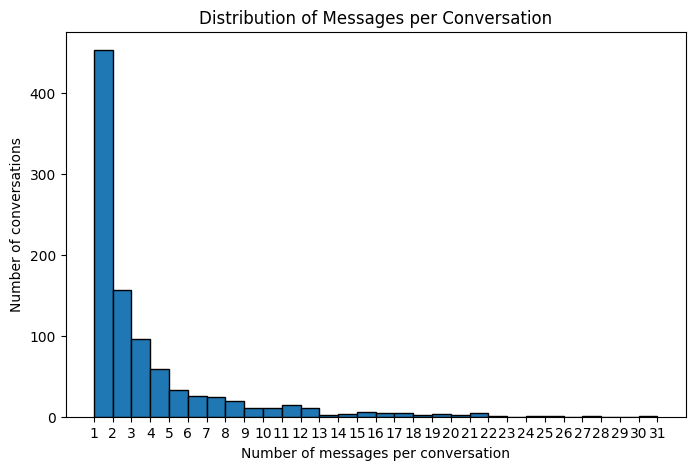

In [9]:
# Group by thread_id and count messages in each conversation
msg_counts = messages.groupby('thread_id').size()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(msg_counts, bins=30, edgecolor='black')
plt.xlabel("Number of messages per conversation")
plt.ylabel("Number of conversations")
plt.xticks(range(1, msg_counts.max() + 1))
plt.title("Distribution of Messages per Conversation")
plt.show()

## Feature Engineering

In [10]:
# Convert timestamp column to datetime
messages['timestamp'] = pd.to_datetime(messages['timestamp'])

In [11]:
# Load spaCy model for NER (use 'en_core_web_sm' or better)
nlp = spacy.load("en_core_web_sm")
# Load the scispaCy small scientific model
nlp_sci = spacy.load("en_core_sci_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

def extract_dates(text):
    # SpaCy can extract dates but may need more domain adaptation for medical dates
    doc = nlp(text)
    dates = [ent.text for ent in doc.ents if ent.label_ == 'DATE']
    return dates

def extract_medical_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # range -1 (negative) to +1 (positive)

def extract_medical_info(text):
    keywords = [
        'bite', 'fracture', 'injury', 'pain', 'missed work', 'surgery',
        'sprain', 'strain', 'dislocation', 'bruise', 'laceration', 'cut',
        'burn', 'swelling', 'concussion', 'headache', 'nausea', 'dizziness',
        'back pain', 'neck pain', 'whiplash', 'hematoma', 'abrasion',
        'contusion', 'infection', 'stitches', 'bruise', 'injured', 'wound',
        'therapy', 'rehabilitation', 'physical therapy', 'medical condition',
        'chronic', 'acute', 'disability', 'hospitalized', 'doctor visit',
        'emergency room', 'ER', 'x-ray', 'MRI', 'CT scan', 'diagnosis',
        'treatment', 'medication', 'prescription', 'allergy', 'side effect',
        'pain medication', 'analgesic', 'anti-inflammatory', 'rest',
        'recovery', 'follow-up', 'complications', 'physical limitation',
        'occupational therapy', 'injury report', 'workers compensation',
        'accident', 'trauma', 'incident'
    ]
    found = [kw for kw in keywords if kw in text.lower()]
    return found



In [12]:
# Apply extraction functions
messages['entities'] = messages['content'].apply(extract_entities)
messages['dates'] = messages['content'].apply(extract_dates)
messages['sentiment'] = messages['content'].apply(analyze_sentiment)
messages['medical_entities'] = messages['content'].apply(extract_medical_entities)
messages['medical_info'] = messages['content'].apply(extract_medical_info)

In [13]:
messages['entities']

0       [(morning, TIME), (Cooper, PERSON), (2, CARDIN...
1       [(1, CARDINAL), (Animal Care Specialist, ORG),...
2                     [(800, CARDINAL), (749-3044, DATE)]
3       [(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...
4       [(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...
                              ...                        
3074                                                   []
3075    [(Sarah, PERSON), (Meadowbrook Hospital 2 hour...
3076                                    [(Smith, PERSON)]
3077    [(Smith, PERSON), (September 3rd2024, DATE), (...
3078                                                   []
Name: entities, Length: 3079, dtype: object

In [14]:
messages['dates']

0                               [a good weekend]
1                                             []
2                                     [749-3044]
3                                             []
4                             [today, Wednesday]
                          ...                   
3074                                          []
3075                               [several day]
3076                                          []
3077    [September 3rd2024, September 10th 2024]
3078                                          []
Name: dates, Length: 3079, dtype: object

## Message Volume Over Time

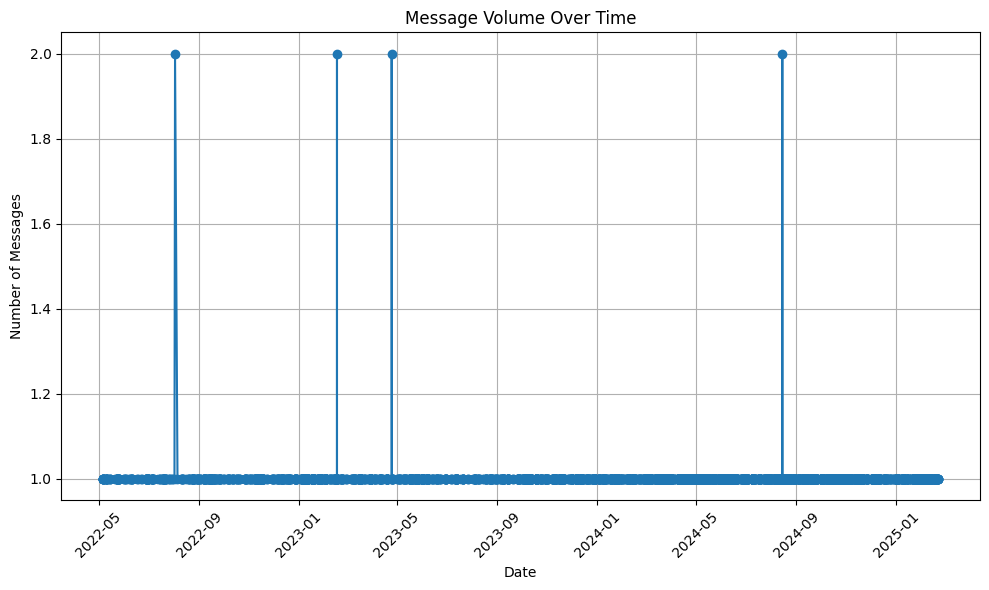

In [15]:
message_volume = messages.groupby('timestamp').size()

# Plot message volume over time
plt.figure(figsize=(10, 6))
plt.plot(message_volume.index, message_volume.values, marker='o', linestyle='-')
plt.title('Message Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
message_volume

timestamp
2022-05-06 13:39:04    1
2022-05-06 16:10:26    1
2022-05-06 16:19:10    1
2022-05-06 16:19:34    1
2022-05-06 16:59:47    1
                      ..
2025-02-20 17:43:12    1
2025-02-20 19:10:11    1
2025-02-20 19:55:20    1
2025-02-21 14:06:42    1
2025-02-21 15:04:55    1
Length: 3075, dtype: int64

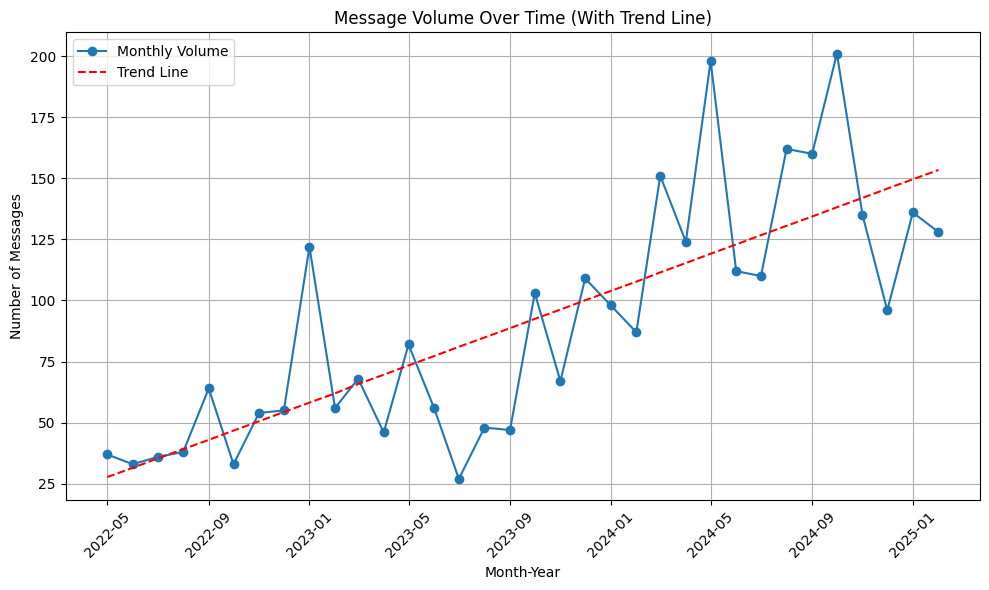

In [131]:
# Create month_year period
messages['month_year'] = messages['timestamp'].dt.to_period('M')

# Calculate monthly message counts
message_volume = messages.groupby('month_year').size()

# Convert index to numeric for regression (e.g., 0, 1, 2…)
x_numeric = np.arange(len(message_volume))
y = message_volume.values

# Fit linear regression (degree=1)
coeffs = np.polyfit(x_numeric, y, deg=1)
trend = np.poly1d(coeffs)

# Plot original data
plt.figure(figsize=(10, 6))
plt.plot(message_volume.index.to_timestamp(), y, marker='o', linestyle='-', label='Monthly Volume')

# Plot trend line
plt.plot(
    message_volume.index.to_timestamp(),
    trend(x_numeric),
    color='red',
    linestyle='--',
    label='Trend Line'
)

plt.title('Message Volume Over Time (With Trend Line)')
plt.xlabel('Month-Year')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

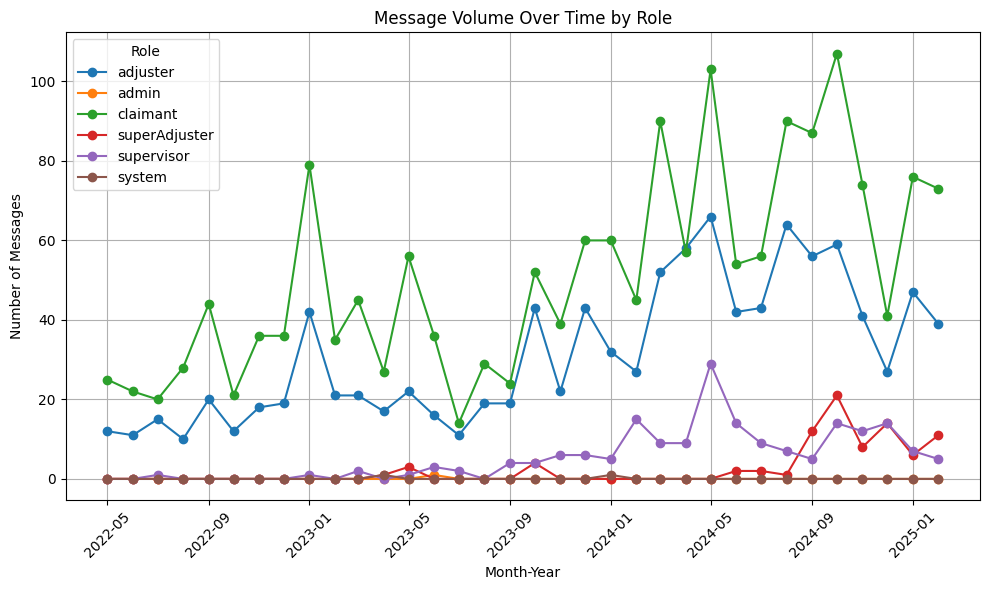

In [130]:
# Group by month_year and role
message_volume_role = (
    messages.groupby(['month_year', 'role'])
    .size()
    .reset_index(name='count')
)

# Pivot so each role is a separate column
message_volume_pivot = message_volume_role.pivot(
    index='month_year', columns='role', values='count'
).fillna(0)

# Plot trends for each role
plt.figure(figsize=(10, 6))
for role in message_volume_pivot.columns:
    plt.plot(
        message_volume_pivot.index.to_timestamp(),
        message_volume_pivot[role],
        marker='o',
        linestyle='-',
        label=role
    )

plt.title('Message Volume Over Time by Role')
plt.xlabel('Month-Year')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.legend(title='Role')
plt.grid(True)
plt.tight_layout()
plt.show()

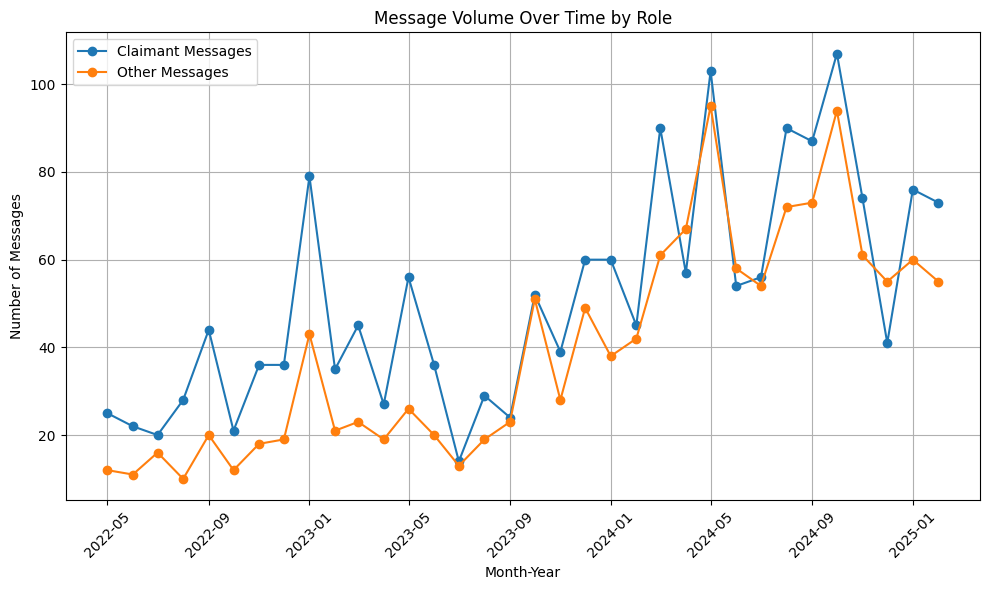

In [132]:
# Separate claimant vs others
claimant_msgs = messages[messages['role'].str.lower() == 'claimant']
other_msgs = messages[messages['role'].str.lower() != 'claimant']

# Group by month-year
claimant_counts = claimant_msgs.groupby('month_year').size()
other_counts = other_msgs.groupby('month_year').size()

# Align indexes (fill missing with 0)
all_months = pd.period_range(messages['month_year'].min(), messages['month_year'].max(), freq='M')
claimant_counts = claimant_counts.reindex(all_months, fill_value=0)
other_counts = other_counts.reindex(all_months, fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(claimant_counts.index.to_timestamp(), claimant_counts.values, marker='o', label='Claimant Messages')
plt.plot(other_counts.index.to_timestamp(), other_counts.values, marker='o', label='Other Messages')

plt.title('Message Volume Over Time by Role')
plt.xlabel('Month-Year')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Most common words

In [18]:
# Combine all text
all_text = ' '.join(messages['content']).lower()

# Tokenize and clean
tokens = word_tokenize(all_text)
words = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]


# ✅ Most Common Words
word_freq = Counter(words)
print("Most common words:")
print(word_freq.most_common(10))

Most common words:
[('please', 898), ('thank', 766), ('work', 753), ('good', 701), ('appointment', 614), ('sarah', 613), ('time', 448), ('medical', 442), ('claim', 394), ('call', 389)]


In [19]:
# ✅ Most Common Bigrams
bigrams = zip(words, words[1:])
bigram_phrases = [' '.join(b) for b in bigrams]
bigram_freq = Counter(bigram_phrases)

In [20]:
# ✅ Most Common Phrases (using CountVectorizer for n-grams)
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X = vectorizer.fit_transform(messages['content'])
sum_words = X.sum(axis=0)
trigram_freq = {
    phrase: int(sum_words[0, idx])
    for phrase, idx in vectorizer.vocabulary_.items()
}



In [21]:
combined_freq = word_freq + bigram_freq + Counter(trigram_freq)

In [22]:
combined_freq 

Counter({'good': 701,
         'morning': 364,
         'cooper': 2,
         'moments': 1,
         'give': 112,
         'call': 389,
         'discuss': 29,
         'accident': 371,
         'unable': 68,
         'please': 898,
         'answer': 66,
         'following': 149,
         'job': 236,
         'department': 105,
         'supervisor': 111,
         'brief': 105,
         'description': 116,
         'size': 2,
         'dog': 4,
         'location': 51,
         'body': 164,
         'bitten': 2,
         'prior': 193,
         'injury': 367,
         'affected': 3,
         'part': 40,
         'medical': 442,
         'conditions': 102,
         'require': 5,
         'maintenance': 3,
         'medication': 73,
         'missed': 80,
         'time': 448,
         'work': 753,
         'result': 10,
         'thank': 766,
         'weekend': 16,
         'animal': 2,
         'care': 165,
         'specialist': 40,
         'riverside': 41,
         'county': 86,
 

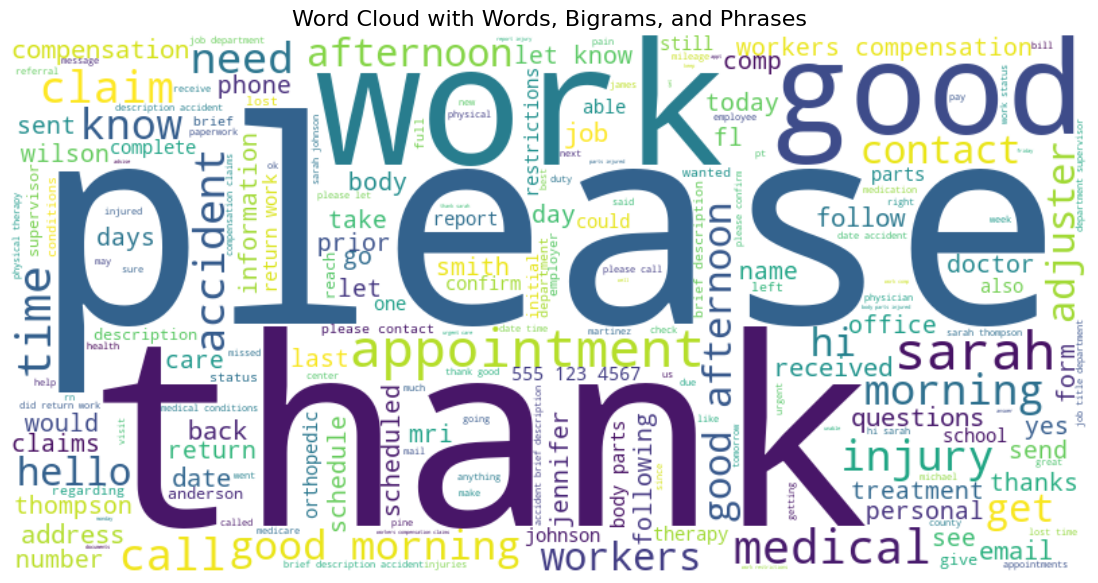

In [23]:
# Merge all frequencies — ensure all keys are strings
combined_freq = {}

# Add word frequencies (already strings)
for word, freq in word_freq.items():
    combined_freq[word] = freq

# Add bigram frequencies (join tuples to strings)
for bigram, freq in bigram_freq.items():
    combined_freq[' '.join(bigram.split())] = freq  # bigram already string, but safer

# Add trigram frequencies
for phrase, freq in trigram_freq.items():
    combined_freq[phrase] = freq  # already string from CountVectorizer

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_freq)

# Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud with Words, Bigrams, and Phrases", fontsize=16)
plt.show()

In [24]:
# 👇 Add your own list of phrases to ignore
custom_exclusions = {
    "please", "thank you", "thank", "good morning", "good" "good afternoon", "good evening", "hi", "hello"
}

# Normalize to lowercase for consistency
custom_exclusions = {phrase.lower() for phrase in custom_exclusions}

# ✅ Filter unigrams
word_freq = {word: freq for word, freq in word_freq.items() if word not in custom_exclusions}

# ✅ Filter bigrams (already string-joined like 'test sentence')
bigram_freq = {phrase: freq for phrase, freq in bigram_freq.items() if phrase not in custom_exclusions}

# ✅ Filter trigrams
trigram_freq = {phrase: freq for phrase, freq in trigram_freq.items() if phrase not in custom_exclusions}



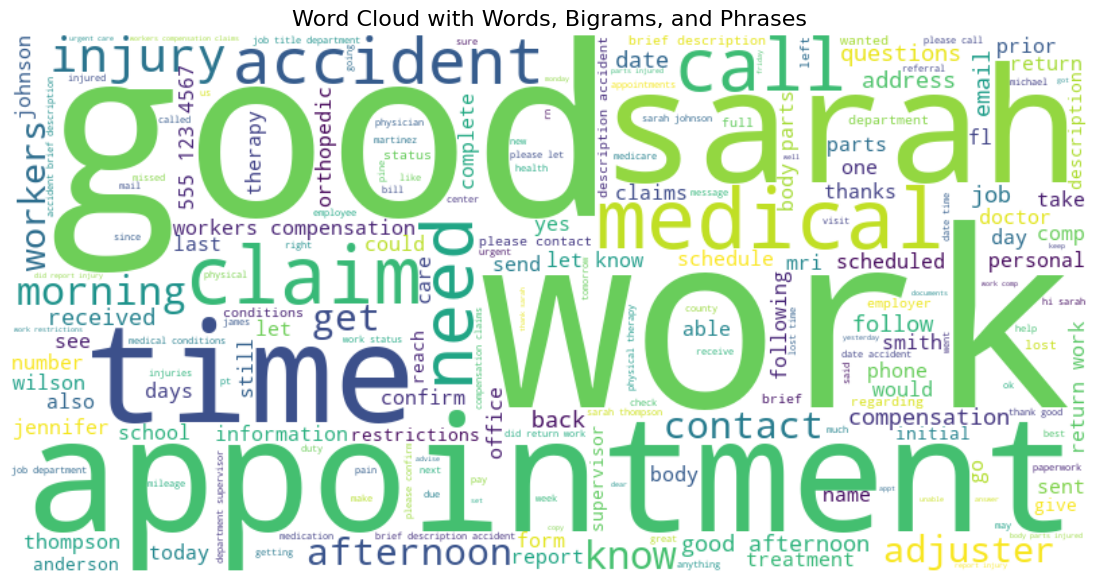

In [25]:
# Merge all frequencies — ensure all keys are strings
combined_freq = {}

# Add word frequencies (already strings)
for word, freq in word_freq.items():
    combined_freq[word] = freq

# Add bigram frequencies (join tuples to strings)
for bigram, freq in bigram_freq.items():
    combined_freq[' '.join(bigram.split())] = freq  # bigram already string, but safer

# Add trigram frequencies
for phrase, freq in trigram_freq.items():
    combined_freq[phrase] = freq  # already string from CountVectorizer

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_freq)

# Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud with Words, Bigrams, and Phrases", fontsize=16)
plt.show()

## Response Times

Boxplot or violin chart: Time taken for different roles to respond, visualized by thread or date. Shows efficiency and bottlenecks.




In [26]:
# Build timeline per thread (min and max timestamp)
timeline = messages.groupby('thread_id')['timestamp'].agg(['min', 'max'])
timeline['duration_hours'] = (timeline['max'] - timeline['min']).dt.total_seconds() / 3600

In [27]:
timeline['duration_hours'].describe()

count      949.000000
mean       372.211340
std       1284.976042
min          0.000000
25%          0.000000
50%          0.023333
75%        138.191389
max      18742.403611
Name: duration_hours, dtype: float64

In [28]:
#look at only threads with positive duration (more than 1 message)
timeline[timeline['duration_hours']>0]['duration_hours'].describe()

count      495.000000
mean       713.593054
std       1710.125334
min          0.000278
25%         10.501389
50%        115.912500
75%        641.146806
max      18742.403611
Name: duration_hours, dtype: float64

In [29]:
timeline[timeline['duration_hours']>0]['duration_hours'].quantile(0.90)

2028.4053333333343

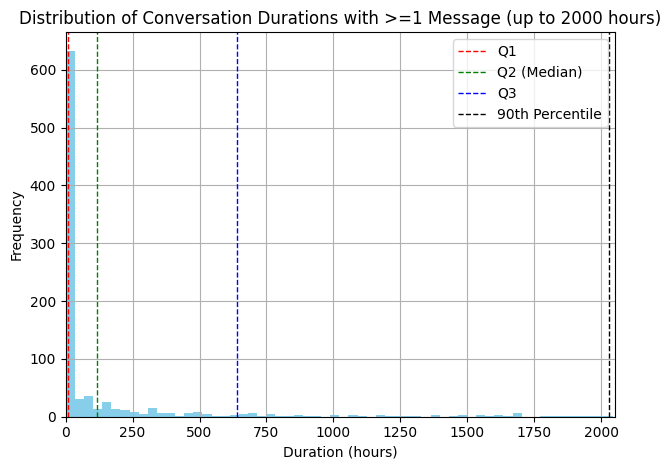

In [30]:
plt.hist(timeline[timeline['duration_hours']<=2050]['duration_hours'], bins=60, color='skyblue')
plt.title("Distribution of Conversation Durations with >=1 Message (up to 2000 hours)")
plt.xlabel("Duration (hours)")
plt.ylabel("Frequency")
plt.xlim(0, 2050)
plt.grid(True)
plt.tight_layout()
#add quartile lines
plt.axvline(timeline[timeline['duration_hours']>0]['duration_hours'].quantile(0.25), color='red', linestyle='dashed', linewidth=1, label='Q1')
plt.axvline(timeline[timeline['duration_hours']>0]['duration_hours'].quantile(0.5), color='green', linestyle='dashed', linewidth=1, label='Q2 (Median)')
plt.axvline(timeline[timeline['duration_hours']>0]['duration_hours'].quantile(0.75), color='blue', linestyle='dashed', linewidth=1, label='Q3')
plt.axvline(timeline[timeline['duration_hours']>0]['duration_hours'].quantile(0.90), color='black', linestyle='dashed', linewidth=1, label='90th Percentile')
plt.legend()
plt.savefig('conversation_durations_with_quartiles.png')
plt.show()

Scatter plot: Response times versus thread size or over time.

##  Message Sentiment

In [34]:
messages['sentiment'] 

0       0.109375
1       0.112500
2       0.000000
3       0.250000
4      -0.500000
          ...   
3074   -0.100000
3075   -0.015909
3076    0.000000
3077    0.175000
3078    0.000000
Name: sentiment, Length: 3079, dtype: float64

In [31]:
# Aggregate sentiment per thread
sentiment_summary = messages.groupby('thread_id')['sentiment'].mean().reset_index(name='avg_sentiment')

# Combine timeline and sentiment
thread_summary = timeline.reset_index().merge(sentiment_summary, on='thread_id')

print(thread_summary)

# Identify threads with long duration or low sentiment (potential bottlenecks or unhappy claimants)
long_duration_threshold = 48  # hours
low_sentiment_threshold = -0.2

issues = thread_summary[
    (thread_summary['duration_hours'] > long_duration_threshold) | 
    (thread_summary['avg_sentiment'] < low_sentiment_threshold)
]

print("Threads with potential issues:")
print(issues)

     thread_id                 min                 max  duration_hours  \
0            0 2024-06-07 14:47:59 2024-07-09 16:12:15      769.404444   
1            1 2024-03-20 19:45:18 2024-03-27 12:39:59      160.911389   
2            2 2024-04-09 19:29:08 2024-04-15 13:40:37      138.191389   
3            3 2023-01-10 17:22:58 2023-01-10 18:25:18        1.038889   
4            4 2024-03-12 15:32:38 2024-03-12 15:32:38        0.000000   
..         ...                 ...                 ...             ...   
944        944 2022-09-19 13:27:36 2022-09-19 13:27:36        0.000000   
945        945 2024-04-11 14:06:24 2024-04-11 14:06:24        0.000000   
946        946 2022-07-01 13:39:39 2022-07-01 13:39:39        0.000000   
947        947 2022-10-04 13:30:59 2022-10-04 13:30:59        0.000000   
948        948 2024-09-05 13:56:09 2024-09-13 13:33:04      191.615278   

     avg_sentiment  
0        -0.004688  
1         0.420833  
2         0.150000  
3         0.010000  
4     

In [32]:
claimant_messages = messages[messages['role'] == 'claimant']

In [33]:
claimant_messages

,thread_id,timestamp,role,content,entities,dates,sentiment,medical_entities,medical_info,month_year
1,0,2024-06-10 13:18:38,claimant,1. What is your job title/department? Animal C...,"[(1, CARDINAL), (Animal Care Specialist, ORG),...",[],0.112500,"[(1, CARDINAL), (Animal Care Specialist, ORG),...","[injury, medical condition, medication, accident]",2024-06
4,0,2024-07-02 03:35:15,claimant,I was unable to make it to an appointment on 6...,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...","[today, Wednesday]",-0.500000,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...",[],2024-07
8,1,2024-03-27 12:28:08,claimant,Yes ma'am I can,[],[],0.000000,[],[],2024-03
11,2,2024-04-15 13:40:37,claimant,"Hi I'm so sorry I'm just getting back to you, ...",[],[],-0.250000,[],[],2024-04
12,3,2023-01-10 17:22:58,claimant,"Hi,\n\nI'm not sure I want to change. Can I j...","[(second, ORDINAL)]",[],0.270000,"[(second, ORDINAL)]",[treatment],2023-01
...,...,...,...,...,...,...,...,...,...,...
3073,945,2024-04-11 14:06:24,claimant,"Hello, I was told this case would not close un...",[],[],0.000000,[],[],2024-04
3074,946,2022-07-01 13:39:39,claimant,No thanks,[],[],-0.100000,[],[],2022-07
3075,947,2022-10-04 13:30:59,claimant,"Sarah, if you recall in the documentation ther...","[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...",[several day],-0.015909,"[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...","[allergy, accident]",2022-10
3076,948,2024-09-05 13:56:09,claimant,"Hello, Ms.Smith I sent you & sign the paperwor...","[(Smith, PERSON)]",[],0.000000,"[(Smith, PERSON)]",[],2024-09


In [34]:
claimant_messages['contains_medical_info'] = claimant_messages['medical_info'].apply(lambda x: len(x) > 0)

/var/folders/69/w4rwgynx75q3d4nc7qj1lcbw0000gn/T/ipykernel_48583/1583406143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claimant_messages['contains_medical_info'] = claimant_messages['medical_info'].apply(lambda x: len(x) > 0)


In [35]:
claimant_messages['contains_medical_info'].value_counts(normalize=True)

contains_medical_info
False    0.806433
True     0.193567
Name: proportion, dtype: float64

In [36]:
#get most common medical info
most_common_medical_info = claimant_messages['medical_info'].explode().value_counts().head(10)
print("Most common medical info:")
print(most_common_medical_info)

Most common medical info:
medical_info
therapy             69
pain                55
physical therapy    50
injury              49
surgery             32
treatment           28
accident            25
rest                25
x-ray               22
incident            22
Name: count, dtype: int64


In [37]:
#who do the conversations start with?
first_messages = messages.groupby('thread_id').first().reset_index()
first_messages['role'].value_counts()

role
claimant         555
adjuster         273
supervisor        82
superAdjuster     38
admin              1
Name: count, dtype: int64

Text(0.2, 0.2, 'Claimant starts')

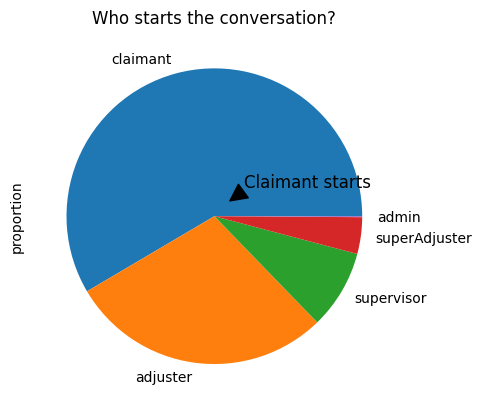

In [38]:
#make pie chart of  who starts the conversation
first_messages['role'].value_counts(normalize=True).plot(kind='pie', title='Who starts the conversation?')
#add annotation about percentage of claimant starts to the pie chart 

plt.annotate('Claimant starts', xy=(0.1, 0.1),
             xytext=(0.2, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='black')    

In [39]:
first_messages['role'].value_counts(normalize=True).values

array([0.58482613, 0.28767123, 0.08640674, 0.04004215, 0.00105374])

Text(0.5, 1.0, 'Who Starts the Conversation?')

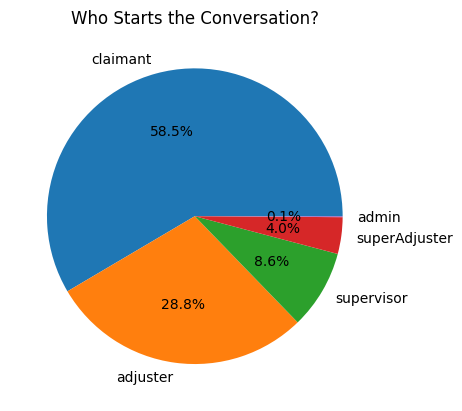

In [40]:
plt.pie(first_messages['role'].value_counts(normalize=True).values, labels=first_messages['role'].value_counts(normalize=True).index, autopct='%.1f%%')
plt.title('Who Starts the Conversation?')



## Question, statement or instruction?

In [41]:
def classify_message(text):
    text = text.strip().lower()
    
    # Acknowledgement keywords
    ack_keywords = ["thanks", "thank you", "okay", "ok", "got it", "sounds good", "sure", "alright", "appreciate it"]
    if any(re.fullmatch(rf".*{kw}.*", text) for kw in ack_keywords):
        return "Acknowledgement"
    
    # Question detection
    if "?" in text or re.match(r"^(can|could|would|will|do|does|did|is|are|was|were|should|what|when|where|why|how)\b", text):
        return "Question"
    
    # Instruction detection
    if re.match(r"^(please|kindly|let's|update|send|check|review|make sure|ensure|attach|follow up)", text):
        return "Instruction"
    
    # Default
    return "Statement"

# Example
examples = [
    "Can you send the file?",
    "Please update the dashboard",
    "The report is ready",
    "Thanks for your help",
    "Okay"
]

for ex in examples:
    print(ex, "->", classify_message(ex))

Can you send the file? -> Question
Please update the dashboard -> Instruction
The report is ready -> Statement
Thanks for your help -> Acknowledgement
Okay -> Acknowledgement


In [42]:
messages['type'] = messages['content'].apply(classify_message)

In [43]:
messages['type'].value_counts()

type
Statement          1613
Acknowledgement     707
Question            700
Instruction          59
Name: count, dtype: int64

## Closed or open?

In [44]:
messages

,thread_id,timestamp,role,content,entities,dates,sentiment,medical_entities,medical_info,month_year,type
0,0,2024-06-07 14:47:59,supervisor,"Good morning, Ms. Cooper - when you have a few...","[(morning, TIME), (Cooper, PERSON), (2, CARDIN...",[a good weekend],0.109375,"[(morning, TIME), (Cooper, PERSON), (2, CARDIN...","[injury, medical condition, medication, accident]",2024-06,Question
1,0,2024-06-10 13:18:38,claimant,1. What is your job title/department? Animal C...,"[(1, CARDINAL), (Animal Care Specialist, ORG),...",[],0.112500,"[(1, CARDINAL), (Animal Care Specialist, ORG),...","[injury, medical condition, medication, accident]",2024-06,Question
2,0,2024-06-10 13:39:40,supervisor,Thank you!!\n\nEmily Martinez\nSupervisor WC T...,"[(800, CARDINAL), (749-3044, DATE)]",[749-3044],0.000000,"[(800, CARDINAL), (749-3044, DATE)]",[],2024-06,Statement
3,0,2024-07-01 19:03:40,supervisor,Hi Sarah - According to the documents from you...,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],0.250000,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],2024-07,Question
4,0,2024-07-02 03:35:15,claimant,I was unable to make it to an appointment on 6...,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...","[today, Wednesday]",-0.500000,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...",[],2024-07,Statement
...,...,...,...,...,...,...,...,...,...,...,...
3074,946,2022-07-01 13:39:39,claimant,No thanks,[],[],-0.100000,[],[],2022-07,Acknowledgement
3075,947,2022-10-04 13:30:59,claimant,"Sarah, if you recall in the documentation ther...","[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...",[several day],-0.015909,"[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...","[allergy, accident]",2022-10,Acknowledgement
3076,948,2024-09-05 13:56:09,claimant,"Hello, Ms.Smith I sent you & sign the paperwor...","[(Smith, PERSON)]",[],0.000000,"[(Smith, PERSON)]",[],2024-09,Acknowledgement
3077,948,2024-09-13 12:32:02,claimant,"Ms. Smith, I went back to work on September 3r...","[(Smith, PERSON), (September 3rd2024, DATE), (...","[September 3rd2024, September 10th 2024]",0.175000,"[(Smith, PERSON), (September 3rd2024, DATE), (...",[],2024-09,Statement


In [45]:
def classify_message(msg):
    msg_lower = msg['content'].lower()
    closed_keywords = ['thanks', 'thank you', 'got it', 'resolved', "that's all", 'done', 'appreciate it']
    open_keywords = ['what', 'how', 'why', '?', 'could you', 'please', "let's", 'when']
    
    
    if msg['type'] == 'Question' or any(word in msg_lower for word in open_keywords):
        return 'open'
    elif msg['type'] == 'Acknowledgement' or any(word in msg_lower for word in closed_keywords):
        return 'closed'
    else:
        return 'unknown'

messages['status'] = messages.apply(classify_message,  axis=1)

In [46]:
messages['status']

0          open
1          open
2        closed
3          open
4       unknown
         ...   
3074     closed
3075       open
3076     closed
3077    unknown
3078     closed
Name: status, Length: 3079, dtype: object

In [47]:
messages[['content','status']]

,content,status
0,"Good morning, Ms. Cooper - when you have a few...",open
1,1. What is your job title/department? Animal C...,open
2,Thank you!!\n\nEmily Martinez\nSupervisor WC T...,closed
3,Hi Sarah - According to the documents from you...,open
4,I was unable to make it to an appointment on 6...,unknown
...,...,...
3074,No thanks,closed
3075,"Sarah, if you recall in the documentation ther...",open
3076,"Hello, Ms.Smith I sent you & sign the paperwor...",closed
3077,"Ms. Smith, I went back to work on September 3r...",unknown


In [48]:
messages[messages['status'] == 'closed']['content']

2       Thank you!!\n\nEmily Martinez\nSupervisor WC T...
9                                      Thank you so much!
15      Hi Jennifer, I have completed the Employee Ear...
20                                            Got it! Ty!
31                                              Thank you
                              ...                        
3069                                               Thanks
3072                                                   Ok
3074                                            No thanks
3076    Hello, Ms.Smith I sent you & sign the paperwor...
3078                                           Thank you!
Name: content, Length: 567, dtype: object

In [49]:
closing_messages = ['thanks', 'ty','ok', 'got it', 'appreciate it', 'will do', 'understood', 'noted', 'sounds good', 'all clear', 'resolved', 'thank you', 'thank you so much', 'thank you very much', 'thanks a lot', 'thanks for your help', 'thanks for your assistance', 'thanks for your support', 'thank you for your help', 'thank you for your assistance', 'thank you for your support']

In [50]:
messages[messages['status'] == 'open']['content']

0       Good morning, Ms. Cooper - when you have a few...
1       1. What is your job title/department? Animal C...
3       Hi Sarah - According to the documents from you...
5       Hi Sarah, I hope you're doing well. Could you ...
7       Good morning, Michael, MediFirst Care didn't u...
                              ...                        
3062    She said she has a knee immobilizer brace that...
3066    Good afternoon,\nI am your workers compensatio...
3068    We have referred you to orthopedic at Sunshine...
3071    Good afternoon, \nPlease fill out pharmacy rei...
3075    Sarah, if you recall in the documentation ther...
Name: content, Length: 1508, dtype: object

In [51]:
messages['content'][:20]

0     Good morning, Ms. Cooper - when you have a few...
1     1. What is your job title/department? Animal C...
2     Thank you!!\n\nEmily Martinez\nSupervisor WC T...
3     Hi Sarah - According to the documents from you...
4     I was unable to make it to an appointment on 6...
5     Hi Sarah, I hope you're doing well. Could you ...
6       I got your voicemail. Perfect glad all is good.
7     Good morning, Michael, MediFirst Care didn't u...
8                                       Yes ma'am I can
9                                    Thank you so much!
10    Good afternoon, I have been trying to reach yo...
11    Hi I'm so sorry I'm just getting back to you, ...
12    Hi,\n\nI'm not sure I want to change.  Can I j...
13    Unfortunately, Workers Compensation doesn't of...
14    Hi would you please give me a call at 555 123 ...
15    Hi Jennifer, I have completed the Employee Ear...
16    Hi Sarah! This is Jennifer Smith, the adjuster...
17    Good afternoon,\nI am your workers compens

In [52]:
messages

,thread_id,timestamp,role,content,entities,dates,sentiment,medical_entities,medical_info,month_year,type,status
0,0,2024-06-07 14:47:59,supervisor,"Good morning, Ms. Cooper - when you have a few...","[(morning, TIME), (Cooper, PERSON), (2, CARDIN...",[a good weekend],0.109375,"[(morning, TIME), (Cooper, PERSON), (2, CARDIN...","[injury, medical condition, medication, accident]",2024-06,Question,open
1,0,2024-06-10 13:18:38,claimant,1. What is your job title/department? Animal C...,"[(1, CARDINAL), (Animal Care Specialist, ORG),...",[],0.112500,"[(1, CARDINAL), (Animal Care Specialist, ORG),...","[injury, medical condition, medication, accident]",2024-06,Question,open
2,0,2024-06-10 13:39:40,supervisor,Thank you!!\n\nEmily Martinez\nSupervisor WC T...,"[(800, CARDINAL), (749-3044, DATE)]",[749-3044],0.000000,"[(800, CARDINAL), (749-3044, DATE)]",[],2024-06,Statement,closed
3,0,2024-07-01 19:03:40,supervisor,Hi Sarah - According to the documents from you...,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],0.250000,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],2024-07,Question,open
4,0,2024-07-02 03:35:15,claimant,I was unable to make it to an appointment on 6...,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...","[today, Wednesday]",-0.500000,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...",[],2024-07,Statement,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
3074,946,2022-07-01 13:39:39,claimant,No thanks,[],[],-0.100000,[],[],2022-07,Acknowledgement,closed
3075,947,2022-10-04 13:30:59,claimant,"Sarah, if you recall in the documentation ther...","[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...",[several day],-0.015909,"[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...","[allergy, accident]",2022-10,Acknowledgement,open
3076,948,2024-09-05 13:56:09,claimant,"Hello, Ms.Smith I sent you & sign the paperwor...","[(Smith, PERSON)]",[],0.000000,"[(Smith, PERSON)]",[],2024-09,Acknowledgement,closed
3077,948,2024-09-13 12:32:02,claimant,"Ms. Smith, I went back to work on September 3r...","[(Smith, PERSON), (September 3rd2024, DATE), (...","[September 3rd2024, September 10th 2024]",0.175000,"[(Smith, PERSON), (September 3rd2024, DATE), (...",[],2024-09,Statement,unknown


In [53]:
#extract persons involved from entities
def extract_persons(entities):
    persons = [ent[0] for ent in entities if ent[1] == 'PERSON']
    return persons

In [54]:
messages['persons_involved'] = messages['entities'].apply(extract_persons)

In [55]:
messages['persons_involved']

0             [Cooper]
1       [Robert Brown]
2                   []
3              [Sarah]
4                   []
             ...      
3074                []
3075           [Sarah]
3076           [Smith]
3077           [Smith]
3078                []
Name: persons_involved, Length: 3079, dtype: object

In [56]:
#get list of different entities involved in all conversations
entities_list = messages['entities'].explode().dropna().unique()
entities_list = [ent[0] for ent in entities_list]

In [57]:
entities_list 

['morning',
 'Cooper',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 'a good weekend',
 '1',
 'Animal Care Specialist',
 'Riverside County Animal Services',
 'Robert Brown',
 'Just 2 hours',
 '6/3/24',
 '800',
 '749-3044',
 'Sarah',
 'MedFirst',
 '06/29/2024',
 '6/29',
 'today',
 '2:20pm',
 'Wednesday',
 'Michael',
 'MediFirst Care',
 'afternoon',
 'about 5 minutes',
 'tomorrow',
 'second',
 'Workers Compensation',
 '2nd',
 '555 123 4567',
 'Jennifer',
 'the Employee Earnings Report',
 'July',
 'August',
 'September',
 'section 6',
 'section three',
 'Employee Earnings Report',
 'May and June',
 'Robert Smith',
 'Jennifer Smith',
 'Wellness PT Center',
 '3 pm',
 'Mailing Address',
 '8',
 'Sarah Thompson',
 'Smith',
 '10:30am',
 '2500',
 '100',
 'Pine Grove',
 'FL',
 '32789',
 '555',
 'Anderson RN',
 'Mailing Address',
 'Cell/Home Phone',
 'Height & Weight',
 'Email',
 'Jarvis\nEmail Address',
 'hours/days',
 'the same day',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 'Restrictions',
 '16',

## better version

In [58]:
# ========== 1) Patterns ==========
INTENT_PATTERNS_INS = {
    "Acknowledgement/Thanks": [
        r"^(thanks|thank you|thx|ty|appreciate (it|your help)|much appreciated)\b",
        r"^(ok|okay|got it|understood|sounds good|noted|will do|done)\b",
        r"^(perfect|great|awesome)$"
    ],
    "Greeting/Opening": [
        r"^(hi|hello|hey|good (morning|afternoon|evening))\b"
    ],
    "Information Request": [
        r"\bplease (provide|answer|confirm|send|advise)\b",
        r"\b(can|could|would|will)\b.*\b(you|u)\b",
        r"\b(let me know|pls (advise|send))\b",
        r"\?\s*$"
    ],
    "Status Request": [
        r"\b(status|update|follow ?up|check(ing)? in)\b",
        r"\bany (update|news|progress)\b",
        r"\bETA\b"
    ],
    "Status Update": [
        r"\b(i (have|haven't|ve|did|finished|completed|submitted|sent|received|got))\b",
        r"\b(per (doctor|records|email|our call))\b",
        r"\bfor your records\b"
    ],
    "Scheduling/Appointment": [
        r"\bappointment\b|\bappt\b|\breschedul(e|ing)\b|\bcancel(l)?\b",
        r"\b(date|time|slot|availability|available)\b",
        r"\b(unable|couldn'?t|can't) to (make|attend|come)\b",
        r"\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b",
        r"\b(\d{1,2}[/-]\d{1,2}([/-]\d{2,4})?)\b",                           # dates like 12/8/22
        r"\b(\d{1,2}:\d{2}\s?(am|pm))\b"                                    # times like 2:30 pm
    ],
    "Call/Contact Request": [
        r"\b(give|gave) me a call\b|\bplease call\b|\bcall me\b",
        r"\btext me\b|\bsend me a text\b|\bemail me\b|\breach (me|out)\b",
        r"\bphone\b|\b\d{3}[-.)\s]?\d{3}[-.\s]?\d{4}\b"                     # phone number-ish
    ],
    "Document Submission/Request": [
        r"\b(attached|attach(ed)?|enclosed|upload(ed)?|sent)\b.*\b(form|paperwork|document|docs|letter|report)\b",
        r"\bplease (send|upload|fill|complete)\b.*\b(form|paperwork|document|docs)\b",
        r"\b(DWC-?\d+|FROI|HIPAA|release|authorization)\b"
    ],
    "Medical Update": [
        r"\b(ordered|prescribed|referred)\b.*\b(mri|x-?ray|ct|ultrasound|pt|physical therapy|orthopedic|injection|rx)\b",
        r"\bdoctor\b.*\b(note|order|visit|referral)\b",
        r"\b(pharmacy|medication|rx|script)\b"
    ],
    "Work Status": [
        r"\b(return(ed)? to work|went back to work|back to work|missed .* (day|days))\b",
        r"\b(light duty|restricted duty|work restrictions?)\b",
        r"\b(out of work|OOO)\b"
    ],
    "Affirmation/Negation": [
        r"^(yes|yep|yeah|sure|of course|no|nope|nah)\b",
        r"\bno thanks\b|\bnot interested\b"
    ],
    "Escalation/Complaint": [
        r"\b(tried|trying) to reach\b|\bbeen trying\b",
        r"\bnot (happy|satisfied|okay|sure)\b|\bconcern\b|\bcomplain\b|\bunfortunately\b",
        r"\bdelay(ed)?\b|\bstill waiting\b"
    ],
    "Voicemail Reference": [
        r"\b(got|received|left) (your )?voicemail\b|\bVM\b"
    ],
    "Decision/Preference": [
        r"\b(i (don’t|do not|won't) want to change|i’ll stay|i prefer|i choose)\b"
    ],
    "Unreachable/Unavailability": [
        r"\b(sorry.*(late|delay))\b|\bjust getting back\b",
        r"\b(unavailable|busy) (today|now|at that time)\b"
    ],
    "Identity/Intro": [
        r"\bthis is\b.*\b(adjuster|nurse|case manager|supervisor|claimant)\b",
        r"\bclaim( number| #|no\.)\b|\bwc\b|\bworkers'? compensation\b"
    ],
}

COMPILED = {k: [re.compile(p, re.IGNORECASE) for p in pats]
            for k, pats in INTENT_PATTERNS_INS.items()}


In [59]:
# ========== 2) Multi-label + context-first ==========
DATE_APPT_REGEXES = [
    re.compile(r"\b(\d{1,2}[/-]\d{1,2}([/-]\d{2,4})?)\b"),
    re.compile(r"\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b", re.IGNORECASE),
    re.compile(r"\b(appointment|appt|reschedul(e|ing)|cancel(l)?)\b", re.IGNORECASE),
    re.compile(r"\b(\d{1,2}:\d{2}\s?(am|pm))\b", re.IGNORECASE)
]

def classify_insurance_intents_multi(text: str) -> list[str]:
    if not isinstance(text, str) or not text.strip():
        return []
    t = text.strip()
    pre = ["Scheduling/Appointment"] if any(rx.search(t) for rx in DATE_APPT_REGEXES) else []
    hits = []
    for intent, regs in COMPILED.items():
        if any(rx.search(t) for rx in regs):
            hits.append(intent)
    # de-dupe, keep order, ensure context-first intent at front
    final = []
    for x in pre + hits:
        if x not in final:
            final.append(x)
    # optional suppression: if a clear ask exists, drop pure ack
    if "Information Request" in final and "Acknowledgement/Thanks" in final:
        final = [i for i in final if i != "Acknowledgement/Thanks"]
    return final


In [60]:
# ========== 3) Role-aware primary ==========
PRIORITY_DEFAULT = [
    "Escalation/Complaint","Medical Update","Work Status","Decision/Preference","Unreachable/Unavailability",
    "Identity/Intro","Status Update","Acknowledgement/Thanks","Affirmation/Negation","Call/Contact Request","Scheduling/Appointment",
    "Voicemail Reference","Information Request","Status Request","Document Submission/Request","Greeting/Opening"
]
PRIORITY_BY_ROLE = {
    "claimant": [
        "Scheduling/Appointment","Information Request","Status Request","Call/Contact Request",
        "Document Submission/Request","Medical Update","Work Status",
        "Acknowledgement/Thanks","Affirmation/Negation","Decision/Preference",
        "Unreachable/Unavailability","Escalation/Complaint","Identity/Intro","Status Update","Greeting/Opening"
    ],
    "adjuster": [
        "Information Request","Document Submission/Request","Call/Contact Request","Scheduling/Appointment",
        "Status Update","Status Request","Identity/Intro","Medical Update","Work Status",
        "Acknowledgement/Thanks","Affirmation/Negation","Escalation/Complaint","Decision/Preference",
        "Unreachable/Unavailability","Greeting/Opening"
    ]
}

def pick_primary_intent(intents: list[str], role_value: str | None = None) -> str:
    if not intents:
        return "Unclassified"
    pri = PRIORITY_DEFAULT
    if role_value and isinstance(role_value, str):
        key = role_value.strip().lower()
        if key in PRIORITY_BY_ROLE:
            pri = PRIORITY_BY_ROLE[key]
    order = {k:i for i,k in enumerate(pri)}
    return sorted(intents, key=lambda x: order.get(x, 999))[0]

### check for other languages

In [61]:
# ========== 4) Language detection ==========
# Returns (lang, score). If not English with good confidence, mark "Non-English".
def detect_language(text: str, english_code="en", min_conf=0.90):
    if not isinstance(text, str) or not text.strip():
        return ("und", 0.0, False)
    lang, score = langid.classify(text)
    is_english = (lang == english_code and score >= min_conf)
    return (lang, score, is_english)



In [62]:
# ========== 5) Apply to a DataFrame ==========
# Expect: messages has 'content' and optional 'role'
def classify_dataframe(messages: pd.DataFrame, text_col="content", role_col="role"):
    df = messages.copy()
    # language detection
    lang_triplet = df[text_col].apply(detect_language)
    df['language']      = lang_triplet.apply(lambda x: x[0])
    df['lang_conf']     = lang_triplet.apply(lambda x: x[1])
    df['is_english']    = lang_triplet.apply(lambda x: x[2])

    # classify only English with confidence; else mark Non-English
    df['intents'] = df.apply(
        lambda r: classify_insurance_intents_multi(r[text_col]),
        axis=1
    )
    # primary (role-aware)
    if role_col in df.columns:
        df['intent_primary'] = df.apply(lambda r: pick_primary_intent(r['intents'], r[role_col]), axis=1)
    else:
        df['intent_primary'] = df['intents'].apply(pick_primary_intent)
    return df

In [63]:
#messages: DataFrame with at least 'content'; if available, include 'role'
out = classify_dataframe(messages, text_col='content', role_col='role')

In [64]:
# Inspect

out['intent_primary'].value_counts()

intent_primary
Information Request            848
Scheduling/Appointment         600
Unclassified                   461
Call/Contact Request           244
Acknowledgement/Thanks         236
Greeting/Opening               155
Status Update                  146
Affirmation/Negation           100
Work Status                     87
Status Request                  63
Document Submission/Request     42
Identity/Intro                  38
Medical Update                  29
Escalation/Complaint            28
Unreachable/Unavailability       2
Name: count, dtype: int64

In [65]:
out[['content','role','language','lang_conf','intents','intent_primary']].head()

,content,role,language,lang_conf,intents,intent_primary
0,"Good morning, Ms. Cooper - when you have a few...",supervisor,en,-1242.979353,"[Greeting/Opening, Information Request, Schedu...",Medical Update
1,1. What is your job title/department? Animal C...,claimant,en,-1365.813179,"[Scheduling/Appointment, Medical Update]",Scheduling/Appointment
2,Thank you!!\n\nEmily Martinez\nSupervisor WC T...,supervisor,en,-38.228105,"[Acknowledgement/Thanks, Identity/Intro]",Identity/Intro
3,Hi Sarah - According to the documents from you...,supervisor,en,-211.618737,"[Scheduling/Appointment, Greeting/Opening, Inf...",Scheduling/Appointment
4,I was unable to make it to an appointment on 6...,claimant,en,-283.933177,[Scheduling/Appointment],Scheduling/Appointment


In [66]:
out[out['intent_primary'] == 'Medical Update']['content'].to_list()

['Good morning, Ms. Cooper - when you have a few moments can you give me a call to discuss your accident? If you are unable to call, then please answer the following:\n\n1. What is your job title/department? \n2. Who is the department supervisor? \n3. Brief description of accident: \n4. Size of the dog and location on body that you were bitten: \n5. Prior injury to the affected body part? \n6. Any medical conditions that require maintenance medication? \n7. Have you missed any time from work as a result of this accident? \n\nThank you and have a good weekend!',
 'Hello! My doctor instructed me that he ordered an MRI for my right knee. Is there a list of doctors in the area who offer that service,',
 'Okay thank you. I will reach out to them for the script for physical therapy. As soon as its received we will send to PhysioNet. They will contact you to schedule your therapy at a location near you.',
 'Just to provide you with an update your PT script was received by our office this morn

In [67]:
out[out['intent_primary'] == 'Information Request']['content'].to_list()

["Good morning, Michael, MediFirst Care didn't upload any paperwork on their portal. Did they happen to give you paperwork at your visit that you could upload here for me?",
 'Good afternoon, I have been trying to reach you about your workers compensation claim. Are you available for about 5 minutes anytime tomorrow? I also need to confirm that you have returned to work since your accident. Can you please provide the date that you returned to work? Thank you.',
 'Hi would you please give me a call at 555 123 4567 i have couple of concerns that I would like to speak personally. Thank you',
 'Can you please advise if you have followed up anywhere medically?',
 'Good evening Emily,\n\nI am your workers compensation adjuster and had some questions regarding your claim.\nPlease confirm the following demographics:\nFull Name:\nMailing Address:\nSS#:\nCell/Home Phone:\nAge & DOB:\nHeight & Weight:\nBest contact number:\nPreferred method of correspondence? Mail, Email or Jarvis\nEmail Address:

In [69]:
out[out['intent_primary'] == 'Escalation/Complaint']['content'].to_list()

["Hi,\n\nI'm not sure I want to change.  Can I just go get a second opinion.  I'd like to be able to choose which care provider offers the best course of treatment,",
 "I am not sure why I am receiving this, since I don't think this was a work related injury. I had AFIB palpitations that sent me to the hospital, it's a preexisting condition I have. Not work related at all.",
 'Good afternoon, Apologies for the delay. You are welcome to call our office anytime between 8:30a and 5p est. Mon-Friday. I can be reached at 800-555-1234. We received the medical notes from your initial appointment with MediCare Plus, but nothing from your follow up. Were you given a referral? If so and you happen to have a copy of it please feel free to upload it here in the portal (you can take a picture of it with your phone or scan it).',
 'Hi. So glad to hear this. I am not sure what the paperwork from ABC Insurance is, but will be glad to look at it.',
 "I  still haven't heard from you . I need to see a do

## compact version

In [113]:
import re

COMPACT_PATTERNS = {
    "Greeting/Acknowledgement": [
        r"^(?:hi|hello|hey|yes|good (?:morning|afternoon|evening))\b",
        r"^(?:thanks|thank you|thx|ty|yw|you'?re welcome)\b",
        r"^(?:ok|okay|got it|understood|sounds good|noted|will do|done|perfect|great|awesome)\b",
        r"^(?:no|nope|nah)\.?\s*$",
        r"\b(?:got|received|left) (?:your )?voicemail\b|\bVM\b",
    ],

    "Request": [
        r"\bplease (?:provide|answer|confirm|send|advise|resend|re-send)\b",
        r"\b(?:can|could|would|will|where|when)\b.*\b(?:you|u|i)\b",
        r"\b(?:status|update|follow ?up|check(?:ing)? in|double[- ]checking)\b",
        r"\b(?:any|have a)\s+(?:update|question|news|progress)\b|\bETA\b",
        r"\b(?:i\s+(?:was|am|'m)\s+)?just?\s*wondering\b",
        r"\bhave a question\b",                      # “I have a question”
        r"\?\s*$",                                   # ends with question mark
    ],

    "Scheduling": [
        r"\b(?:appointment|appt|reschedul(?:e|ing)|cancel(?:l)?)\b",
        r"\b(?:date|time|slot|availability|available)\b",
        r"\b(?:unable|couldn'?t|can't)\s+to\s+(?:make|attend|come)\b",
        r"\b(?:monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b",
        r"\b\d{1,2}[/-]\d{1,2}(?:[/-]\d{2,4})?\b|\b\d{1,2}:\d{2}\s?(?:am|pm)\b",
        # provider/facility lines that look like locations (helps classify address drops)
        r"\b(?:clinic|medical|center|hospital|imaging|orthopedic|care|health|insurance)\b.*\d{3,}.*\b[A-Z]{2}\b",
    ],

    "Contact/Logistics": [
        r"\b(?:give|gave) me a call\b|\bplease call\b|\bcall me\b|\bphone\b",
        r"\b(?:text|email)\s+me\b|\bsend me a text\b|\breach\s+(?:me|out)\b",
        r"\b\d{3}[-.)\s]?\d{3}[-.\s]?\d{4}\b",  # phone-ish
        r"\b(?:sorry.*(?:late|delay)|just getting back|unavailable|busy (?:today|now|at that time))\b",
        r"\b(?:can'?t|cannot|won'?t)\s+(?:hear|review|sign|submit|open|access)\b",  # “won’t let me review and sign”
        r"https?://\S+",                        # links/portals
        r"\b(?:resent|re-sent|re sent)\b.*\b(?:email|link)\b",  # “I re-sent the email”
    ],

    "Documents": [
        r"\b(?:attach(?:ed)?|enclosed|upload(?:ed)?|sent|submit(?:ted)?)\b.*\b(?:form|paperwork|document|docs|letter|report|photo|photos|picture|pictures)\b",
        r"\bplease\s+(?:send|upload|fill|complete|sign|resend|re-send)\b.*\b(?:form|paperwork|document|docs)\b",
        r"\b(?:mileage\s+reimbursement|additional\s+forms?)\b",
        r"\b(?:DWC-?\d+|FROI|HIPAA|release|authorization)\b",
        r"\byou may attach (?:the )?photos\b",
        r"\bappear next to the other forms\b",  # “should appear next to the other forms…”
    ],

    "Medical/Work Update": [
        r"\b(?:ordered|prescribed|referred)\b.*\b(?:mri|x-?ray|ct|ultrasound|pt|physical therapy|orthopedic|injection|rx|referral)\b",
        r"\bdoctor\b.*\b(?:note|order|visit|referral)\b|\b(?:pharmacy|medication|rx|script)\b",
        r"\b(?:ice|elevation|elevat(?:e|ion)|voltren|voltaren|bc powder|pain|hurts|tolerable)\b",
        r"\b(?:return(?:ed)?|went back|back)\s+to\s+work\b|\bmissed\s+\d+\s+(?:day|days)\b|\b(?:light|restricted)\s+duty\b|\bout of work\b|\bOOO\b",
        r"\b(?:finger|injury|clot)\b",          # “following up about my finger”, “clot wasn’t ortho”
        r"\breferral has been sent\b",          # “Your MRI Referral has been sent…”
    ],

    "Escalation/Decision/Identity": [
        r"\b(?:tried|trying|been trying)\s+to\s+reach\b|\bstill waiting\b|\bdelay(?:ed)?\b|\bunfortunately\b",
        r"\bnot\s+(?:happy|satisfied|okay|sure)\b|\bconcern\b|\bcomplain\b",
        r"\b(?:contact|call)\s+my\s+lawyer\b|\blawyer\b",  # legal threat
        r"\b(?:i (?:don’t|do not|won't) want to change|i’ll stay|i prefer|i choose|error)\b",
        r"\bthis is\b.*\b(?:adjuster|nurse|case manager|supervisor|claimant)\b|\bclaim(?: number| #|no\.)\b|\bworkers'? compensation\b",
    ],
}

COMPILED_COMPACT = {k: [re.compile(p, re.IGNORECASE) for p in v] for k,v in COMPACT_PATTERNS.items()}

messages['content'] = messages['content'].astype(str).fillna("")

def classify_compact_multi(row):
    # row can be a Series or dict; get content safely
    text = row.get('content', '')
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    t = text.strip().lower()
    if not t:
        return []

    hits = []
    # use your compiled regex dict: COMPILED_COMPACT
    for intent, regs in COMPILED_COMPACT.items():
        if any(rx.search(t) for rx in regs):
            hits.append(intent)

    # optional: medical flag if you have a column
    medical = row.get('medical_info', [])  # could be list/str/None
    if (isinstance(medical, (list, tuple)) and len(medical) > 0) or \
       (isinstance(medical, str) and medical.strip()):
        if "Medical/Work Update" not in hits:
            hits.append("Medical/Work Update")


    #if type = = "Question", thebn add "Request" intent
    if row.get('type') == 'Question' and "Request" not in hits:
        hits.append("Request")

    #if type == "Acknowledgement", then add "Acknowledgement" intent
    if row.get('type') == 'Acknowledgement' and "Greeting/Acknowledgement" not in hits:
        hits.append("Greeting/Acknowledgement")
    # If there's a clear Request, suppress pure Greeting/Ack
    if "Request" in hits and "Greeting/Acknowledgement" in hits:
        hits = [h for h in hits if h != "Greeting/Acknowledgement"]

    return hits


def pick_primary_compact(intents: list[str], role_val: str | None = None) -> str:
    PRIORITY_DEFAULT = ["Request","Scheduling","Documents","Medical/Work Update",
                        "Contact/Logistics","Greeting/Acknowledgement","Escalation/Decision/Identity"]
    PRIORITY_BY_ROLE = {
        "claimant": ["Scheduling","Request","Contact/Logistics","Documents","Medical/Work Update",
                     "Greeting/Acknowledgement","Escalation/Decision/Identity"],
        "adjuster": ["Request","Documents","Contact/Logistics","Scheduling","Medical/Work Update",
                     "Greeting/Acknowledgement","Escalation/Decision/Identity"],
    }
    if not intents:
        return "Unknown"
    pri = PRIORITY_BY_ROLE.get((role_val or "").strip().lower(), PRIORITY_DEFAULT)
    order = {k:i for i,k in enumerate(pri)}
    return sorted(intents, key=lambda x: order.get(x, 999))[0]

In [114]:
# Multi-label compact intents:
messages['intents'] = messages.apply(classify_compact_multi, axis=1)

# Primary compact (role-aware):
if 'role' in messages.columns:
    messages['intent_primary'] = messages.apply(
        lambda r: pick_primary_compact(r['intents'], r['role']), axis=1
    )
else:
    messages['intent_primary'] = messages['intents'].apply(pick_primary_compact)

In [115]:
messages

,thread_id,timestamp,role,content,entities,dates,sentiment,medical_entities,medical_info,month_year,type,status,persons_involved,intents,intent_primary
0,0,2024-06-07 14:47:59,supervisor,"Good morning, Ms. Cooper - when you have a few...","[(morning, TIME), (Cooper, PERSON), (2, CARDIN...",[a good weekend],0.109375,"[(morning, TIME), (Cooper, PERSON), (2, CARDIN...","[injury, medical condition, medication, accident]",2024-06,Question,open,[Cooper],"[Request, Scheduling, Contact/Logistics, Medic...",Request
1,0,2024-06-10 13:18:38,claimant,1. What is your job title/department? Animal C...,"[(1, CARDINAL), (Animal Care Specialist, ORG),...",[],0.112500,"[(1, CARDINAL), (Animal Care Specialist, ORG),...","[injury, medical condition, medication, accident]",2024-06,Question,open,[Robert Brown],"[Scheduling, Medical/Work Update, Request]",Scheduling
2,0,2024-06-10 13:39:40,supervisor,Thank you!!\n\nEmily Martinez\nSupervisor WC T...,"[(800, CARDINAL), (749-3044, DATE)]",[749-3044],0.000000,"[(800, CARDINAL), (749-3044, DATE)]",[],2024-06,Statement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
3,0,2024-07-01 19:03:40,supervisor,Hi Sarah - According to the documents from you...,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],0.250000,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],2024-07,Question,open,[Sarah],"[Request, Scheduling]",Request
4,0,2024-07-02 03:35:15,claimant,I was unable to make it to an appointment on 6...,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...","[today, Wednesday]",-0.500000,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...",[],2024-07,Statement,unknown,[],[Scheduling],Scheduling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074,946,2022-07-01 13:39:39,claimant,No thanks,[],[],-0.100000,[],[],2022-07,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
3075,947,2022-10-04 13:30:59,claimant,"Sarah, if you recall in the documentation ther...","[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...",[several day],-0.015909,"[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...","[allergy, accident]",2022-10,Acknowledgement,open,[Sarah],"[Medical/Work Update, Greeting/Acknowledgement]",Medical/Work Update
3076,948,2024-09-05 13:56:09,claimant,"Hello, Ms.Smith I sent you & sign the paperwor...","[(Smith, PERSON)]",[],0.000000,"[(Smith, PERSON)]",[],2024-09,Acknowledgement,closed,[Smith],"[Greeting/Acknowledgement, Documents]",Documents
3077,948,2024-09-13 12:32:02,claimant,"Ms. Smith, I went back to work on September 3r...","[(Smith, PERSON), (September 3rd2024, DATE), (...","[September 3rd2024, September 10th 2024]",0.175000,"[(Smith, PERSON), (September 3rd2024, DATE), (...",[],2024-09,Statement,unknown,[Smith],[Medical/Work Update],Medical/Work Update


In [116]:
#how many intents on average per message
messages['intents'].apply(len).mean()

1.7427736278012342

In [117]:
messages['intents'].value_counts()

intents
[Greeting/Acknowledgement]                                                                    514
[Request]                                                                                     443
[]                                                                                            336
[Request, Scheduling]                                                                         196
[Request, Scheduling, Medical/Work Update]                                                    140
                                                                                             ... 
[Documents, Medical/Work Update, Greeting/Acknowledgement]                                      1
[Request, Contact/Logistics, Documents, Medical/Work Update, Escalation/Decision/Identity]      1
[Escalation/Decision/Identity, Medical/Work Update]                                             1
[Documents, Escalation/Decision/Identity, Greeting/Acknowledgement]                             1
[Scheduling,

In [118]:
messages[messages['intents'].apply(len)==0]['content'].to_list()

['I just sent you a new one.',
 'Madison',
 'One is the 1st one that has already been paid out. The other one that is mostly September is the new one.',
 'That was prior to the water bottle situation',
 'Sterling Insurance',
 'It appears so but did you submit it. I do not see completed on my end.',
 "It won't let me review and sign it",
 'Figured it out- had to check no on other box to I guess.',
 'One earning report per a month.',
 'Robert Martinez\n\nBegin forwarded message:',
 'Waiting for next steps.',
 'My hourly rate is wrong on your paperwork by hourly rate of pay is $18.01',
 'Please see the attached PT order.',
 'I have imaging order and referral order',
 'I uploaded the papers I have, hope you can see them .',
 'We should get them eventually. If you are up to it you may send them.',
 'About 9 am will be fine',
 'It is a monthly form. You will complete it at the end of the month each month.',
 'It is a monthly form. You will complete it at the end of the month each month.',
 '

In [128]:
mask = messages['intents'].apply(lambda x: x == ["Greeting/Acknowledgement"])
messages[mask]

,thread_id,timestamp,role,content,entities,dates,sentiment,medical_entities,medical_info,month_year,type,status,persons_involved,intents,intent_primary
2,0,2024-06-10 13:39:40,supervisor,Thank you!!\n\nEmily Martinez\nSupervisor WC T...,"[(800, CARDINAL), (749-3044, DATE)]",[749-3044],0.000000,"[(800, CARDINAL), (749-3044, DATE)]",[],2024-06,Statement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
6,1,2024-03-20 19:45:18,adjuster,I got your voicemail. Perfect glad all is good.,[],[],0.733333,[],[],2024-03,Statement,unknown,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
8,1,2024-03-27 12:28:08,claimant,Yes ma'am I can,[],[],0.000000,[],[],2024-03,Statement,unknown,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
9,1,2024-03-27 12:39:59,adjuster,Thank you so much!,[],[],0.250000,[],[],2024-03,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
20,8,2022-11-22 16:21:43,claimant,Got it! Ty!,[],[],0.000000,[],[],2022-11,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,938,2025-02-03 19:22:12,adjuster,Ok. I have reached out to the office. The Dr. ...,[],[],0.000000,[],[],2025-02,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
3069,942,2024-10-22 14:04:06,claimant,Thanks,[],[],0.200000,[],[],2024-10,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
3072,944,2022-09-19 13:27:36,claimant,Ok,[],[],0.500000,[],[],2022-09,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
3074,946,2022-07-01 13:39:39,claimant,No thanks,[],[],-0.100000,[],[],2022-07,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement


In [121]:
messages

,thread_id,timestamp,role,content,entities,dates,sentiment,medical_entities,medical_info,month_year,type,status,persons_involved,intents,intent_primary
0,0,2024-06-07 14:47:59,supervisor,"Good morning, Ms. Cooper - when you have a few...","[(morning, TIME), (Cooper, PERSON), (2, CARDIN...",[a good weekend],0.109375,"[(morning, TIME), (Cooper, PERSON), (2, CARDIN...","[injury, medical condition, medication, accident]",2024-06,Question,open,[Cooper],"[Request, Scheduling, Contact/Logistics, Medic...",Request
1,0,2024-06-10 13:18:38,claimant,1. What is your job title/department? Animal C...,"[(1, CARDINAL), (Animal Care Specialist, ORG),...",[],0.112500,"[(1, CARDINAL), (Animal Care Specialist, ORG),...","[injury, medical condition, medication, accident]",2024-06,Question,open,[Robert Brown],"[Scheduling, Medical/Work Update, Request]",Scheduling
2,0,2024-06-10 13:39:40,supervisor,Thank you!!\n\nEmily Martinez\nSupervisor WC T...,"[(800, CARDINAL), (749-3044, DATE)]",[749-3044],0.000000,"[(800, CARDINAL), (749-3044, DATE)]",[],2024-06,Statement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
3,0,2024-07-01 19:03:40,supervisor,Hi Sarah - According to the documents from you...,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],0.250000,"[(Sarah, PERSON), (MedFirst, ORG), (06/29/2024...",[],2024-07,Question,open,[Sarah],"[Request, Scheduling]",Request
4,0,2024-07-02 03:35:15,claimant,I was unable to make it to an appointment on 6...,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...","[today, Wednesday]",-0.500000,"[(6/29, CARDINAL), (today, DATE), (2:20pm, CAR...",[],2024-07,Statement,unknown,[],[Scheduling],Scheduling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074,946,2022-07-01 13:39:39,claimant,No thanks,[],[],-0.100000,[],[],2022-07,Acknowledgement,closed,[],[Greeting/Acknowledgement],Greeting/Acknowledgement
3075,947,2022-10-04 13:30:59,claimant,"Sarah, if you recall in the documentation ther...","[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...",[several day],-0.015909,"[(Sarah, PERSON), (Meadowbrook Hospital 2 hour...","[allergy, accident]",2022-10,Acknowledgement,open,[Sarah],"[Medical/Work Update, Greeting/Acknowledgement]",Medical/Work Update
3076,948,2024-09-05 13:56:09,claimant,"Hello, Ms.Smith I sent you & sign the paperwor...","[(Smith, PERSON)]",[],0.000000,"[(Smith, PERSON)]",[],2024-09,Acknowledgement,closed,[Smith],"[Greeting/Acknowledgement, Documents]",Documents
3077,948,2024-09-13 12:32:02,claimant,"Ms. Smith, I went back to work on September 3r...","[(Smith, PERSON), (September 3rd2024, DATE), (...","[September 3rd2024, September 10th 2024]",0.175000,"[(Smith, PERSON), (September 3rd2024, DATE), (...",[],2024-09,Statement,unknown,[Smith],[Medical/Work Update],Medical/Work Update


In [129]:
messages.to_csv('classified_messages_through_analysis.csv', index=False)